In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [3]:
!pip install -q findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=a42a8eec23b7f93f704391c555c8b91f68e089342edac1436c4900bc595705c7
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import findspark
findspark.init()

In [6]:
from pyspark.sql import SparkSession

In [7]:
APP_NAME = "Final_Project_Code_gb563"

In [8]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [9]:
spark

# Load dataset from file

In [10]:
data = spark.read.csv('/content/gdrive/MyDrive/DSCI 632/Ortho_COVID_632.csv',header=True,inferSchema = True)
data.show(5, truncate=False)

+----+------+---+------------------+----+---+---------+-------+-------+-------+--------+--------+--------+-----+-----+------+--------+--------+--------+-----+------+---------+---------+
|YEAR|ADMQTR|CPT|BMI               |Age |SEX|FNSTATUS2|ASACLAS|STEROID|ASCITES|VENTILAT|DIABETES|HYPERMED|HXCHF|SMOKE|HXCOPD|DIALYSIS|DISCANCR|BLEEDDIS|PRHCT|PRSODM|MORTALITY|MORBIDITY|
+----+------+---+------------------+----+---+---------+-------+-------+-------+--------+--------+--------+-----+-----+------+--------+--------+--------+-----+------+---------+---------+
|0   |1.0   |0  |27.70313379620942 |75.0|0.0|0.0      |3.0    |0      |0      |0       |0       |1       |0    |1    |0     |0       |0       |0       |42.2 |139.0 |0        |0        |
|0   |1.0   |1  |33.83324661810614 |66.0|1.0|0.0      |2.0    |0      |0      |0       |0       |0       |0    |0    |0     |0       |0       |0       |42.2 |136.0 |0        |0        |
|0   |1.0   |1  |23.672448979591838|39.0|0.0|0.0      |1.0    |0      

# Let's check data types

In [11]:
data.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- ADMQTR: double (nullable = true)
 |-- CPT: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- SEX: double (nullable = true)
 |-- FNSTATUS2: double (nullable = true)
 |-- ASACLAS: double (nullable = true)
 |-- STEROID: integer (nullable = true)
 |-- ASCITES: integer (nullable = true)
 |-- VENTILAT: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- HYPERMED: integer (nullable = true)
 |-- HXCHF: integer (nullable = true)
 |-- SMOKE: integer (nullable = true)
 |-- HXCOPD: integer (nullable = true)
 |-- DIALYSIS: integer (nullable = true)
 |-- DISCANCR: integer (nullable = true)
 |-- BLEEDDIS: integer (nullable = true)
 |-- PRHCT: double (nullable = true)
 |-- PRSODM: double (nullable = true)
 |-- MORTALITY: integer (nullable = true)
 |-- MORBIDITY: integer (nullable = true)



Data description:
* Year: integer 0-4 corresponding to 2017-2021
* ADMQTR: Admit quarter, 1-4 corresponding to annual quarter
* CPT: Current Procedural Terminology code, 0 = Knee Arthroplasty, 1 = Hip Arhtroplasty
* BMI: Body Mass Index
* Age: age in years
* SEX: Gender, 0 = Male, 1 = Female
* FNSTATUS2: Post-operative functional status, 0 = independent, 1 = partially dependent, 2 = fully dependent
* ASACLAS: American Society of Anesthesiologists Physical Status Score, 1-5
* STEROID: steroid use, 0 = No, 1 = Yes
* ASCITES: ascitic abdominal fluid, 0 = No, 1 = Ye
* VENTILAT: pre-operative ventilator requirement
* DIABETES: 0 = No, 1 = Yes (medication dependent)
* HYPERMED: high blood pressure
* HXCHF: Congestive heart failure, 0 = No, 1 = Yes
* SMOKE: Smoker, 0 = No, 1 = Yes
* HXCOPD: Chronic obtructive pulmonary disease, 0 = No, 1 = Yes
* DIALYSIS: dialysis dependent, 0 = No, 1 = Yes
* DISCANCR: Cancer, 0 = No, 1 = Yes
* BLEEDDIS: Bleeding disorder, 0 = No, 1 = Yes
* PRHCT: Pre-operative hematocrit, float
* PRSODM: Pre-operative sodium level, float
* MORTALITY: Death within 30 days, 0 = No, 1 = Yes
* MORBIDITY: Morbidity within 30 days, 0 = No, 1 = Yes

# Let's drop missing values

In [12]:
print('Original dataset has {:d} patients'.format(data.count()))
print('')
data2=data.dropna(how='any')
print('After dropping rows with missing data, new dataset has {:d} patients'.format(data2.count()))

Original dataset has 508103 patients

After dropping rows with missing data, new dataset has 455476 patients


# Data Exploration

Let's build the Outcome/Target Variable (Combined Morbidity and Mortality). Goal is to set the Target to 1 if either Morbidity or Mortality or both are 1.

In [13]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

def process_target(x,y):
  return 1 if x==1 or y==1 else 0

combo_udf = udf(lambda x,y: process_target(x,y),IntegerType())

data2=data2.withColumn('Target',combo_udf(col('MORBIDITY'),col('MORTALITY')))

data2.groupby('Target').count().show()

+------+------+
|Target| count|
+------+------+
|     1| 16025|
|     0|439451|
+------+------+



Now, let's make train and test datasets. We'll use temporal validation, so we'll train on Years 0-3 (2017-2020) and test on Year 4 (2021)

In [14]:
data_train = data2.filter(data2.YEAR<4)
data_test = data2.filter(data2.YEAR==4)

print('train data:')
data_train.groupby('Target').count().show()
print('')
print('test data:')
data_test.groupby('Target').count().show()

train data:
+------+------+
|Target| count|
+------+------+
|     1| 12865|
|     0|354868|
+------+------+


test data:
+------+-----+
|Target|count|
+------+-----+
|     1| 3160|
|     0|84583|
+------+-----+



Baseline data on outcomes:

In [16]:
data_train.groupBy('Target').count().show()
data_test.groupBy('Target').count().show()

+------+------+
|Target| count|
+------+------+
|     1| 12865|
|     0|354868|
+------+------+

+------+-----+
|Target|count|
+------+-----+
|     1| 3160|
|     0|84583|
+------+-----+



In [17]:
12865/(12865+354868)

0.0349846219947625

In [18]:
3160/(3160+84583)

0.036014268944531184

Now let's explore predictors: Categorical/binary

In [16]:
categorical_variables = ['YEAR','CPT','SEX','FNSTATUS2','ASACLAS','STEROID','ASCITES','VENTILAT','DIABETES',\
                         'HYPERMED','HXCHF','SMOKE','HXCOPD','DIALYSIS','DISCANCR','BLEEDDIS']

print('Train data:')
for cat in categorical_variables:
  data_train.groupby(cat).count().show()

print('')
print('Test data:')
for cat in categorical_variables:
  data_test.groupby(cat).count().show()

Train data:
+----+------+
|YEAR| count|
+----+------+
|   1| 95033|
|   3| 75476|
|   2|106188|
|   0| 91036|
+----+------+

+---+------+
|CPT| count|
+---+------+
|  1|143103|
|  0|224630|
+---+------+

+---+------+
|SEX| count|
+---+------+
|0.0|152193|
|1.0|215540|
+---+------+

+---------+------+
|FNSTATUS2| count|
+---------+------+
|      0.0|362852|
|      1.0|  4660|
|      2.0|   221|
+---------+------+

+-------+------+
|ASACLAS| count|
+-------+------+
|    1.0|  8065|
|    4.0|  6973|
|    3.0|175097|
|    2.0|177598|
+-------+------+

+-------+------+
|STEROID| count|
+-------+------+
|      1| 13381|
|      0|354352|
+-------+------+

+-------+------+
|ASCITES| count|
+-------+------+
|      1|    60|
|      0|367673|
+-------+------+

+--------+------+
|VENTILAT| count|
+--------+------+
|       1|    20|
|       0|367713|
+--------+------+

+--------+------+
|DIABETES| count|
+--------+------+
|       1| 59426|
|       0|308307|
+--------+------+

+--------+------+
|HYP

Predictors: Continuous

In [21]:
data_train.select('BMI','Age','PRHCT','PRSODM').describe().show()
data_test.select('BMI','Age','PRHCT','PRSODM').describe().show()

+-------+------------------+-----------------+-----------------+------------------+
|summary|               BMI|              Age|            PRHCT|            PRSODM|
+-------+------------------+-----------------+-----------------+------------------+
|  count|            367733|           367733|           367733|            367733|
|   mean| 31.91233842961324|66.67665942409302|41.31513600900681|139.71287692429016|
| stddev| 6.542737211342963|10.06055177948963|4.022911625023297|2.7466470798973397|
|    min|11.524590163934427|             18.0|             18.0|             116.0|
|    max| 79.33159722222223|             90.0|             60.0|             160.0|
+-------+------------------+-----------------+-----------------+------------------+

+-------+------------------+-----------------+------------------+------------------+
|summary|               BMI|              Age|             PRHCT|            PRSODM|
+-------+------------------+-----------------+------------------+--------

# Univariate Analysis

Let's assess which variables are associated with the outcome to plan our multivariable model. We'll just do this with the train data since we don't want to cause a data leak into the test data.

Categorical:

In [18]:
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

vec = VectorAssembler(inputCols=[c for c in categorical_variables],outputCol='variables')
data2_vec_outcome = vec.transform(data_train).select('Target', 'variables')

cat_chi_square = ChiSquareTest.test(data2_vec_outcome, 'variables', 'Target').head()
print('Target:')
for c in range(len(categorical_variables)):
  print('{:s}: p-value = {:.5f}'.format(categorical_variables[c],list(cat_chi_square.pValues)[c]))



Target:
YEAR: p-value = 0.00002
CPT: p-value = 0.00000
SEX: p-value = 0.00000
FNSTATUS2: p-value = 0.00000
ASACLAS: p-value = 0.00000
STEROID: p-value = 0.00000
ASCITES: p-value = 0.00057
VENTILAT: p-value = 0.00006
DIABETES: p-value = 0.00000
HYPERMED: p-value = 0.00000
HXCHF: p-value = 0.00000
SMOKE: p-value = 0.00000
HXCOPD: p-value = 0.00000
DIALYSIS: p-value = 0.00000
DISCANCR: p-value = 0.00000
BLEEDDIS: p-value = 0.00000


Looks like all categorical variables have a significant association with the target outcome

Continuous:

In [19]:
from scipy.stats import mannwhitneyu
continuous_variables = ['BMI','Age','PRHCT','PRSODM']

print('Morbidity or Mortality:')
for cont in continuous_variables:
#make separate dataframes
  data2_no_outcome = data_train.filter(data2.Target==0)
  data2_yes_outcome = data_train.filter(data2.Target==1)
  val,p = mannwhitneyu(data2_no_outcome.select(cont).toPandas()[cont],data2_yes_outcome.select(cont).toPandas()[cont])
  print('{:s}, p-value = {:5f}'.format(cont,p))




Morbidity or Mortality:
BMI, p-value = 0.000000
Age, p-value = 0.000000
PRHCT, p-value = 0.000000
PRSODM, p-value = 0.000000


It appears that all continuous values have significant associations with the outcome on univariate analysis

# Model Building and Multivariable Analysis

In [ ]:
#Let's recast some of the doubles to integers. Age, ASACLAS, FNSTATUS2, and SEX started as doubles since they had NaN's\
#even though the really are just categorical variables

In [20]:
data2=data2.withColumn('Age',col('Age').cast('integer'))
data2=data2.withColumn('ASACLAS',col('ASACLAS').cast('integer'))
data2=data2.withColumn('FNSTATUS2',col('FNSTATUS2').cast('integer'))
data2=data2.withColumn('SEX',col('SEX').cast('integer'))



In [27]:
#dummy variables for categorical, non-binary outcomes
from pyspark.ml.feature import OneHotEncoder
One_Hots = OneHotEncoder(inputCols=['FNSTATUS2','ASACLAS'],outputCols=['FNSTATUS2_OH','ASACLAS_OH'])

#Now assemble a vector.
from pyspark.ml.feature import VectorAssembler
v_assembler = VectorAssembler(inputCols = ['CPT','SEX','FNSTATUS2_OH', 'ASACLAS_OH','STEROID','ASCITES',\
                                           'VENTILAT','DIABETES','HYPERMED','HXCHF','SMOKE','HXCOPD', 'DIALYSIS',\
                                           'DISCANCR','BLEEDDIS','Age','BMI','PRHCT','PRSODM'],outputCol='Inputs')

#Now put the Pipeline together to build feature vectures for further processing
from pyspark.ml import Pipeline
pipe = Pipeline(stages=[One_Hots,v_assembler])

preprocessed_data=pipe.fit(data2).transform(data2)
preprocessed_data.show(10,truncate=False)



+----+------+---+------------------+---+---+---------+-------+-------+-------+--------+--------+--------+-----+-----+------+--------+--------+--------+-----+------+---------+---------+------+-------------+-------------+--------------------------------------------------------------------------------------+
|YEAR|ADMQTR|CPT|BMI               |Age|SEX|FNSTATUS2|ASACLAS|STEROID|ASCITES|VENTILAT|DIABETES|HYPERMED|HXCHF|SMOKE|HXCOPD|DIALYSIS|DISCANCR|BLEEDDIS|PRHCT|PRSODM|MORTALITY|MORBIDITY|Target|FNSTATUS2_OH |ASACLAS_OH   |Inputs                                                                                |
+----+------+---+------------------+---+---+---------+-------+-------+-------+--------+--------+--------+-----+-----+------+--------+--------+--------+-----+------+---------+---------+------+-------------+-------------+--------------------------------------------------------------------------------------+
|0   |1.0   |0  |27.70313379620942 |75 |0  |0        |3      |0      |0      |0

Split data by years to train on years 0-3 (2017-2020) and predict 4 (2021)

In [28]:
data_train_2 = preprocessed_data.filter(preprocessed_data.YEAR<4)
data_test_2 = preprocessed_data.filter(preprocessed_data.YEAR==4)

In [29]:
print('Training data size: ',data_train_2.count())
print('Test data size: ',data_test_2.count())

Training data size:  367733
Test data size:  87743


(1) Logistic Regression

In [30]:
targets = data_train_2.select('Target').collect()
Target='Target'

#Train model
from pyspark.ml.classification import LogisticRegression
model_LR = LogisticRegression(featuresCol='Inputs',labelCol=Target).fit(data_train_2)

#Make Predictions
predictions_LR = model_LR.transform(data_test_2)


(2) Random Forest

In [31]:
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

targets = data_test_2.select('Target').collect()
Target='Target'

#set up grid search
max_depth_grid = [2,4,6,8]
num_trees_grid = [5,10,15]

rf_performance_holder = []
for m in max_depth_grid:
  for n in num_trees_grid: 
    rf = RandomForestClassifier(featuresCol='Inputs',labelCol=Target, numTrees=n,maxDepth = m)
    model_RF = rf.fit(data_train_2)
    predictions_RF = model_RF.transform(data_test_2)
    preds_RF = [i[0][1] for i in predictions_RF.select('probability').collect()]
    AUC_RF = roc_auc_score(targets,preds_RF)
    rf_performance_holder.append((AUC_RF,m,n))

print("best random forest performance:")
print(sorted(rf_performance_holder,key=lambda x: x[0],reverse=True)[0])

best random forest performance:
(0.6115152751615259, 8, 15)


In [32]:
#train final Random Forest model with best hyperparameters
rf = RandomForestClassifier(featuresCol='Inputs',labelCol=Target, numTrees=15,maxDepth = 8)
model_RF = rf.fit(data_train_2)
predictions_RF = model_RF.transform(data_test_2)

(3) Naive Bayes

In [33]:
from pyspark.ml.classification import NaiveBayes

targets = data_test_2.select('Target').collect()
Target='Target'

#set up grid search
alpha = [0.001,0.01,0.1,1,10,100,1000]

nb_performance_holder=[]
for alph in alpha:
  NB = NaiveBayes(smoothing=alph, featuresCol = 'Inputs', labelCol = Target, modelType="multinomial")
  model_NB = NB.fit(data_train_2)
  predictions_NB = model_NB.transform(data_test_2)
  preds_NB = [i[0][1] for i in predictions_NB.select('probability').collect()]
  AUC_NB = roc_auc_score(targets,preds_NB)
  nb_performance_holder.append((AUC_NB,alph))

print("best Naive Bayes performance:")
print(sorted(nb_performance_holder,key=lambda x: x[0],reverse=True)[0])


best Naive Bayes performance:
(0.6108245466179053, 0.001)


In [34]:
#train final Random Forest model with best hyperparameters
NB = NaiveBayes(smoothing=0.001, featuresCol = 'Inputs', labelCol = Target, modelType="multinomial")
model_NB = NB.fit(data_train_2)
predictions_NB = model_NB.transform(data_test_2)

# Model Performance Evaluation

First look at area under the receiver operating characteristic curve

Text(0, 0.5, 'True Positive Rate')

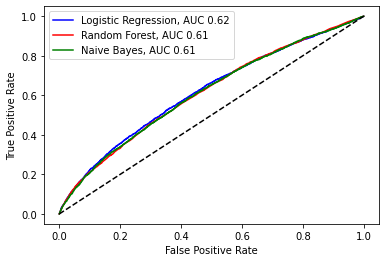

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


preds_LR = [i[0][1] for i in predictions_LR.select('probability').collect()]
preds_RF = [i[0][1] for i in predictions_RF.select('probability').collect()]
preds_NB = [i[0][1] for i in predictions_NB.select('probability').collect()]

AUC_LR = roc_auc_score(targets,preds_LR)
AUC_RF = roc_auc_score(targets,preds_RF)
AUC_NB = roc_auc_score(targets,preds_NB)

fp_LR, tp_LR, _ = roc_curve(targets, preds_LR)
fp_RF, tp_RF, _ = roc_curve(targets, preds_RF)
fp_NB, tp_NB, _ = roc_curve(targets, preds_NB)

plt.plot(fp_LR,tp_LR,'b',label='Logistic Regression, AUC {:.2f}'.format(AUC_LR))
plt.plot(fp_RF,tp_RF,'r',label='Random Forest, AUC {:.2f}'.format(AUC_RF))
plt.plot(fp_NB,tp_NB,'g',label='Naive Bayes, AUC {:.2f}'.format(AUC_NB))

plt.legend()
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


Next look at calibration curve

Text(0.5, 0, 'Predicted Target (%)')

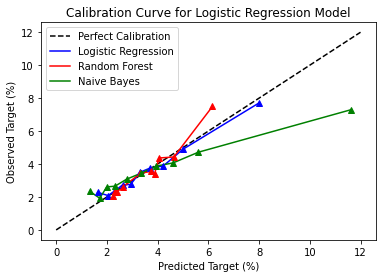

In [36]:
import numpy as np
from sklearn.calibration import calibration_curve

x_LR,y_LR = calibration_curve(targets,preds_LR,n_bins=10,strategy='quantile')
x_RF,y_RF = calibration_curve(targets,preds_RF,n_bins=10,strategy='quantile')
x_NB,y_NB = calibration_curve(targets,preds_NB,n_bins=10,strategy='quantile')

plt.plot([0,12],[0,12],'k--')
plt.plot([100*i for i in y_LR],[100*i for i in x_LR],'b-')
plt.plot([100*i for i in y_RF],[100*i for i in x_RF],'r-')
plt.plot([100*i for i in y_NB],[100*i for i in x_NB],'g-')

plt.plot([100*i for i in y_LR],[100*i for i in x_LR],'b^')
plt.plot([100*i for i in y_RF],[100*i for i in x_RF],'r^')
plt.plot([100*i for i in y_NB],[100*i for i in x_NB],'g^')

plt.legend(['Perfect Calibration','Logistic Regression','Random Forest','Naive Bayes'])
plt.title('Calibration Curve for Logistic Regression Model')
plt.ylabel('Observed Target (%)')
plt.xlabel('Predicted Target (%)')
#plt.ylim(0,1)
#plt.xlim(0,1)
